In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging

sys.path.insert(0,'../src')
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

logger = logging.getLogger("feat_viz")
logging.basicConfig(format='[%(name)s %(levelname)s] %(message)s', level=logging.INFO)

In [14]:
from general_utils import read_spatial_expression, normalize_count_cellranger
from main_methods import multitest_rejections
from matplotlib_venn import venn2,venn3
from io_utils import save_data_to_file, load_data_from_file

def plot_venn3(d, ax):
    set_labels = list(d.keys())
    subsets = [d[k] for k in set_labels]
    v=venn3(subsets=subsets, set_labels=set_labels, ax=ax)
    return v

def load_our_result(fn, alpha):
    result = load_data_from_file(fn, 'csv')
    print('Loaded: {}'.format(fn))
    rej_idx = multitest_rejections(result.pvalue, alpha, method="BH")
    ours = result.geneID[rej_idx]
    return ours

def load_merfish_result():
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    fn =  ddir+'/data/MERFISH/our_results/MERFISH_result_df.csv'
    alpha= 0.05
    ours = load_our_result(fn, alpha)
    # load scgco result
    fileName = ddir + "/data/MERFISH/scGCO_results/MERFISH_result_df.csv"
    result_df = pd.read_csv(fileName, index_col=0)
    fdr05 = result_df[result_df.fdr < alpha].sort_values(by=['fdr'])
    # load SpatialDE result
    de = ddir + "/data/MERFISH/spatialDE_results/middle_final_results.csv"
    counts_de = pd.read_csv(de,index_col=0)
    counts_de=counts_de[counts_de.qval<alpha]
    counts_de=counts_de[counts_de.g.values != 'log_total_count']
    print(counts_de.shape[0])
    return {
        'scGCO': set(fdr05.index.values),
        'SpatialDE': set(counts_de.g.values),
        'Ours': set(ours)
    }


def load_breastcancer_result(j, trendsceek=False):
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    alpha= 0.05
    # load our result
    fn =  ddir+'/data/BreastCancer/our_results/Layer'+ str(j)+'_result_df.csv'
    ours = load_our_result(fn, alpha)
    # load scgco result
    gco = ddir + "/data/BreastCancer/scGCO_results/Layer"+str(j)+"_BC_pattern_conserved_df_exp.csv"
    counts_gco = pd.read_csv(gco,index_col=0)
    print('scGCO: {}'.format(counts_gco.shape))
    # load SpatialDE result
    de = ddir + "/data/BreastCancer/spatialDE_results/Layer" + str(j) + "_BC_final_results.csv"
    counts_de = pd.read_csv(de,index_col=0)
    print('spatialde: {}'.format(counts_de.shape))
    counts_de=counts_de[counts_de.qval<alpha]
    counts_de=counts_de[counts_de.g.values != 'log_total_count']
        
    res =  {
        'scGCO': set(counts_gco.index),
        'SpatialDE': set(counts_de.g.values),
        'Ours': set(ours)
    }
    
    if trendsceek:
        assert j == 2, 'trendsceek is only available for rep 2'
        # load trendsceek result
        fn = ddir + "/data/BreastCancer/trendsceek_results/BC{}_sig_gene_list.csv".format(j)
        counts_sceek=pd.read_csv(fn,index_col=0)
        print('sceek: {}'.format(counts_sceek.shape))
        res['trendsceek'] = set(counts_sceek.sig_gene.values)
        
    return res

def load_mob_result(j):
    # load the mouse oilfacotry bulb 
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    alpha= 0.01
    
    # load the data from our method
    fn =  ddir+'/data/MouseOB/our_results/Rep'+ str(j)+'_result_df.csv'
    ours = load_our_result(fn, alpha)
    
    
    # load scgco result
    fn = ddir+'/data/MouseOB/scGCO_results/Rep'+ str(j)+'_result_df.csv'
    print(fn)
    gco_df = pd.read_csv(fn, index_col=0)
    gco_df = gco_df.loc[gco_df['fdr'] < alpha]
    print(gco_df.shape)

    # load spatial de result
    de_df=pd.read_csv(ddir+'/data/MouseOB/spatialDE_results/Rep'+ str(j)+'_MOB_results.csv')
    de_df=de_df[de_df.qval<0.05]
    de_df=de_df.query("g!='log_total_count'")
    print(de_df.shape)
    
    return {
        'scGCO': set(gco_df.index),
        'SpatialDE': set(de_df.g.values),
        'Ours': set(ours)
    }


def format_scatter(ax):
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        length=0,
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    
def plot_spatial(data, j, ax ):
    ddir = '/share/PI/sabatti/sc_data/spatial_ge/scGCO'
    if data == 'MERFISH':
        ff = ddir + '/data/Raw_data/MERFISH/middle_scGCO_data_matrix.csv'
        sep = ' '
        ms = 3
    if data == 'BC':
        ff = ddir + '/data/Raw_data/MOB-breast-cancer/Layer' + str(j) +  '_BC_count_matrix-1.tsv'
        sep='\t'
        ms = 5
        
    if data == 'MOB':
        ff = ddir + '/data/Raw_data/MOB-breast-cancer/Rep' + str(j) +  '_MOB_count_matrix-1.tsv'
        sep = '\t'
        ms = 5
        
    locs, data =read_spatial_expression(ff, sep=sep)
    ax.scatter(*locs.T, c='k', s=ms)
    format_scatter(ax)
    return data.shape

def plot_all(data, plot_type='coord', fdir=None):
    figsize = (2, 2) 
    if data == 'BC':
        rep_ids = np.arange(1,5)
        pfx = 'Layer-'
    elif data == 'MOB':
        rep_ids = [9, 10, 11]
        pfx = 'Rep-'
    else: # if data == 'MERFISH':
        rep_ids = [data]
        pfx = ''
        figsize = (3, 3) 
    n_plts = len(rep_ids)
    if plot_type == 'coord':    
        for i, val in enumerate(rep_ids):
            fig, ax = plt.subplots(1,1, figsize=figsize)
            dshape = plot_spatial(data, val, ax)
            ax.set_title('{}{}: {}'.format(pfx, val, dshape))
            plt.show()
    if plot_type == 'venn':
        figsize=(3, 3)
        for i, v in enumerate(rep_ids):
            if data == 'BC':
                gsets = load_breastcancer_result(v)
            elif data == 'MOB':
                gsets = load_mob_result(v)
            elif data == 'MERFISH':
                gsets = load_merfish_result()
                figsize = (2,2)
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            vd = plot_venn3(gsets, ax)
            if data == 'MERFISH':
                vd.get_label_by_id("001").set_y(-0.51)
                vd.get_label_by_id("011").set_x(0.41)
                vd.get_label_by_id("101").set_x(-0.45)
            title = '{}{}'.format(pfx, v)
            ax.set_title(title)
            if fdir:
                fn = fdir + 'venn_{}.pdf'.format(title)
                plt.savefig(fn, bbox_inches='tight', transparent=True) 
                print("Saved figure to: {}".format(fn))
            plt.show()
            


# Breast Cancer Sample

raw data dim: (254, 14880)


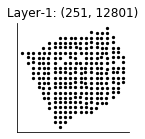

raw data dim: (251, 14789)


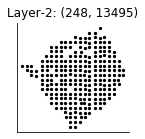

raw data dim: (264, 14929)


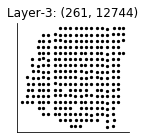

raw data dim: (262, 14808)


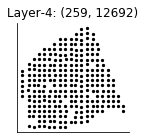

In [63]:
plot_all('BC', plot_type='coord')

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer1_result_df.csv
scGCO: (121, 258)
spatialde: (12962, 18)


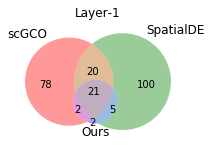

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer2_result_df.csv
scGCO: (118, 255)
spatialde: (12857, 18)


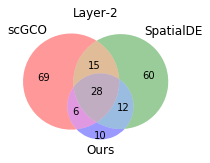

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer3_result_df.csv
scGCO: (77, 268)
spatialde: (12988, 18)


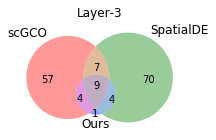

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer4_result_df.csv
scGCO: (90, 266)
spatialde: (12902, 18)


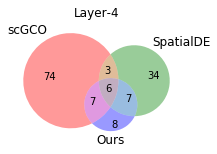

In [81]:
plot_all('BC', plot_type='venn')

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/BreastCancer/our_results/Layer2_result_df.csv
scGCO: (118, 255)
spatialde: (12857, 18)
sceek: (15, 1)
Saved: /scratch/PI/sabatti/spatial_subplots/venn_BC_ours_vs_others.pdf


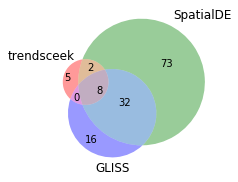

Saved: /scratch/PI/sabatti/spatial_subplots/venn_BC_scGCO_vs_others.pdf


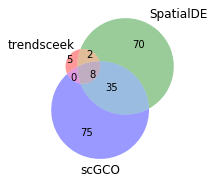

In [89]:
def plot_method_comp(rep2_res, use_list, title, fdir=None):
    ex = {v: rep2_res[v] for v in use_list}
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    plot_venn3(ex, ax)
    if fdir:
        fn = fdir + 'venn_{}.pdf'.format(title)
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print('Saved: {}'.format(fn))
    plt.show()

rep2_res = load_breastcancer_result(2, trendsceek=True)
rep2_res['GLISS'] = rep2_res['Ours']
use_list = ['trendsceek', 'SpatialDE', 'GLISS']
title = 'BC_ours_vs_others'
plot_method_comp(rep2_res, use_list, title, fdir=fdir)

use_list = ['trendsceek', 'SpatialDE', 'scGCO']
title = 'BC_scGCO_vs_others'
plot_method_comp(rep2_res, use_list, title, fdir=fdir)

In [95]:
def overlap_score(setlist):
    intersect = set.intersection(*setlist)
    union = set.union(*setlist)
    return len(intersect) / len(union)

In [ ]:
if len(order) == 3:
        figsize = (2.3,2.3)
    else:
        figsize = (2.3,2)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax = freq_series.plot(kind='bar', color = my_colors, width=0.65, edgecolor='black')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_ylim(0, 1.0)
    ax.set_xticklabels(order, size=10, rotation=90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

SpatialDE
0    0.305344
1    0.226316
dtype: float64
trendsceek
0    0.126984
1    0.064000
dtype: float64
Saved figure to: /scratch/PI/sabatti/spatial_subplots/overlap_bar_BC.pdf


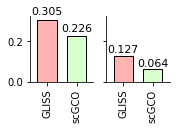

In [122]:
bench_methods = ['SpatialDE', 'trendsceek']
other_methods = ['GLISS', 'scGCO']
my_colors = ['#ffb3b3', '#d8ffcc']
order = other_methods
figsize = (2.5, 1.2)
fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
for i, comp in enumerate(bench_methods):
    ax = axes[i]
    print(comp)
    dd = {}
    for m in other_methods:
        dd[m] = overlap_score([rep2_res[m], rep2_res[comp]])
    freq_series = pd.Series([dd[i] for i in other_methods])
    print(freq_series)
    ax = freq_series.plot(kind='bar', color = my_colors, width=0.65, edgecolor='black', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(order, size=10, rotation=90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    rects = ax.patches

    # Make some labels.
    labels = ['{:.3f}'.format(v) for v in freq_series]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height*1.05, label,
                ha='center', va='bottom', fontsize=11)
fn = fdir + 'overlap_bar_BC.pdf'
plt.savefig(fn, bbox_inches='tight', transparent=True) 
print("Saved figure to: {}".format(fn))
plt.show()

# Mouse Oilfactory Bulb Data

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep11_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep11_result_df.csv
(751, 266)
(67, 19)


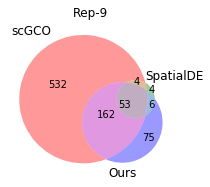

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep11_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep11_result_df.csv
(751, 266)
(67, 19)


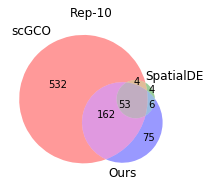

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep11_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep11_result_df.csv
(751, 266)
(67, 19)


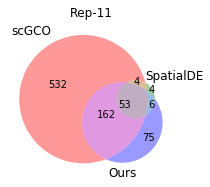

In [72]:
plot_all('MOB', plot_type='venn')

raw data dim: (237, 15284)


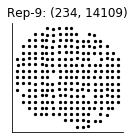

raw data dim: (281, 16416)


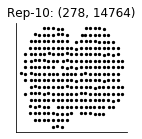

raw data dim: (262, 16218)


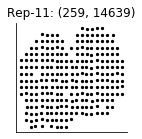

In [73]:
plot_all('MOB', plot_type='coord')

In [68]:
res = {}
for v in [9, 10, 11]:
    res[v] = load_mob_result(v)

Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep9_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep9_result_df.csv
(327, 241)
(142, 19)
Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep10_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep10_result_df.csv
(1330, 285)
(607, 19)
Loaded: /share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/our_results/Rep11_result_df.csv
/share/PI/sabatti/sc_data/spatial_ge/scGCO/data/MouseOB/scGCO_results/Rep11_result_df.csv
(751, 266)
(67, 19)


{'Ours': 0.13107822410147993, 'SpatialDE': 0.06269592476489028, 'scGCO': 0.1023142509135201}
Saved figure to: /scratch/PI/sabatti/spatial_subplots/overlap_bar_MOB_rep.pdf


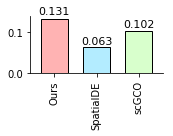

In [129]:
# compute the reproduciblity score   
def plot_bar_vals(ddict, order, my_colors, fn=None):
    freq_series = pd.Series([ddict[i] for i in order])
    figsize = (2.6,2.0)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax = freq_series.plot(kind='bar', color = my_colors, width=0.65, edgecolor='black')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
#     ax.set_ylim(0, 1.0)
    ax.set_xticklabels(order, size=10, rotation=90)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    rects = ax.patches

    # Make some labels.
    labels = ['{:.3f}'.format(v) for v in freq_series]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height*1.05, label,
                ha='center', va='bottom', fontsize=11)
    plt.tight_layout()
    if fn:
        plt.savefig(fn, bbox_inches='tight', transparent=True) 
        print("Saved figure to: {}".format(fn))
    plt.show()
    
    
method = ['Ours', 'SpatialDE', 'scGCO']
colors = ['#ffb3b3', '#b3ecff', '#d8ffcc']
score = {}
for i, m in enumerate(method):        
    dd = [res[k][m] for k in res]
    score[m] = overlap_score(dd)
print(score)
fn = fdir + 'overlap_bar_MOB_rep.pdf'
plot_bar_vals(score, method, colors, fn=fn)

Saved: /scratch/PI/sabatti/spatial_subplots/venn_reprod_MOB_scGCO.pdf


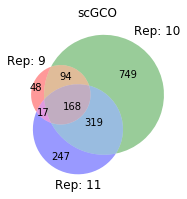

Saved: /scratch/PI/sabatti/spatial_subplots/venn_reprod_MOB_SpatialDE.pdf


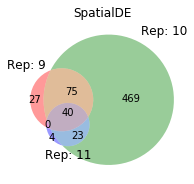

Saved: /scratch/PI/sabatti/spatial_subplots/venn_reprod_MOB_Ours.pdf


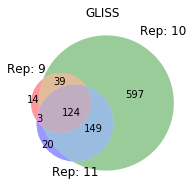

In [82]:
for i, m in enumerate(['scGCO', 'SpatialDE', 'Ours']):    
    dd = {'Rep: {}'.format(k): res[k][m] for k in res}
    # plot the venn diagrams of overlap
    fig, ax = plt.subplots(1, 1, figsize=(3,3))    
    plot_venn3(dd, ax)
    if m == 'Ours':
        title = 'GLISS'
    else:
        title = m
    ax.set_title(title)
    title = 'reprod_MOB_{}'.format(m)
    fn = fdir + 'venn_{}.pdf'.format(title)
    plt.savefig(fn, bbox_inches='tight', transparent=True) 
    print('Saved: {}'.format(fn))
    plt.show()